# Defanging a lion

## Problem statement

In your safari trip, you came across a dangerous lion.

!curl https://storage.googleapis.com/aiolympiadmy/ioai-2025-tsp/ioai2025_tsp_selection2/defanging_lion/francesco-ZxNKxnR32Ng-unsplash.jpg -o lion.jpg

Ensure your safety by transforming the lion in this picture into a slightly less dangerous animal: an african buffalo.

Here is how your work will be scored:

- 1 pt awarded for demonstrating that your transformed lion is closer in meaning to the text "a peaceful african buffalo" than the text "a prowling lion on the hunt" by `openai/clip-vit-base-patch32`

> For CLIP scoring, use cosine similarity for your calculation. Scoring less than 0.5 using the reference implementation of binary softmax is sufficient to be considered as closer to buffalo. To ensure that your implementation is correct, and to save you the headache of losing progress due to not realizing you need to normalize your vectors, sample code is provided below as a reference. I am not mandating you use this code because you might prefer to handle the vectors directly instead of being wrapped in transformers as a dictionary with key "pixel_values"

- 1 pt awarded if the point above is earned, and your transformed lion has less than 0.3 SSIM loss compared to the original lion.

> For SSIM loss, install `kornia` and look at the sample code provided below.

- 1 pt awarded if `openai/clip-vit-base-patch32` considers the softmaxed probability that your transformed lion is a buffalo is higher than 0.7 (i.e. lion < 0.3) AND SSIM loss is less than 0.3
- 2 pts awarded for demonstrating that your transformed lion is so convincingly transformed into a buffalo, that it visually looks more like a buffalo than a lion. SSIM loss criterion not applicable for these points.
    - If it clearly looks like a buffalo to me, these pts will count. If not, I will load any readily-available image classification model pretrained on ImageNet and check if the transformed image is closer to class 291 (lion) or class 346 (water buffalo). The reason for this evaluation is to make sure that you aren't creating an adversarial image that is barely modified but scores the correct class.
    - Make sure that your image is shown in your notebook for further inspection.
- 1 pt awarded for explaining your thought process and reasoning for your work done. Keep it brief, one short paragraph is enough!

Partial credit will be granted at discretion.

You are allowed to use:

- any pretrained model from `torchvision` and `transformers`
- any code and pretrained models made available to you as part of this problem
- standard ML libraries (e.g. numpy, sklearn, albumentations, einops)
- additional images of your own

You are prohibited to use:

- pretrained models that are not from the allowed sources. Off the shelf models, dedicated libraries and github repos are not allowed.
- responses from LLM APIs like OpenAI and using the response as your solution
- hosted local LLMs to generate images and use the generated image as your solution
- any technique that amounts to replacing the lion with a different picture

You might find this mysterious SomeNetwork useful.

Requirements: 
- Install `attrs`. You should already have `numpy`, `torch`, and `torchvision`
- Download `somenetwork.py` from https://storage.googleapis.com/aiolympiadmy/ioai-2025-tsp/ioai2025_tsp_selection2/defanging_lion/somenetwork.py
- Download weights (370+ MB combined):
    - `encoder.pt` from https://storage.googleapis.com/aiolympiadmy/ioai-2025-tsp/ioai2025_tsp_selection2/defanging_lion/encoder.pt
    - `decoder.pt` from https://storage.googleapis.com/aiolympiadmy/ioai-2025-tsp/ioai2025_tsp_selection2/defanging_lion/decoder.pt
- Download `using-somenetwork.ipynb` from https://storage.googleapis.com/aiolympiadmy/ioai-2025-tsp/ioai2025_tsp_selection2/defanging_lion/using-somenetwork.ipynb to see how to use it

## Sample code to help you get started

```python
device = "cuda" if torch.cuda.is_available() else "cpu"

from PIL import Image
import torch.nn.functional as F
from transformers import CLIPModel, CLIPProcessor

processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(device)

text_inputs = processor(
    text="a peaceful african buffalo", return_tensors="pt", padding=True
).to(device)
buffalo_text_embeddings = model.get_text_features(**text_inputs).float()
buffalo_text_embeddings = F.normalize(buffalo_text_embeddings, p=2, dim=-1)

text_inputs = processor(text="a prowling lion on the hunt", return_tensors="pt", padding=True).to(
    device
)
lion_text_embeddings = model.get_text_features(**text_inputs).float()
lion_text_embeddings = F.normalize(lion_text_embeddings, p=2, dim=-1)

image = Image.open("lion.jpg").convert("RGB")
inputs = processor(
    images=image,
    return_tensors="pt",
    padding=True,
    do_rescale=True,
    do_normalize=True,
)
inputs = {k: v.to(device) for k, v in inputs.items()}

def compute_clip_lion2buffalo_loss(image_inputs):
    image_embeddings = model.get_image_features(**image_inputs).float()
    image_embeddings = F.normalize(image_embeddings, p=2, dim=-1)

    global lion_text_embeddings
    global buffalo_text_embeddings

    # Cosine similarity (higher = more similar)
    lion_sim = (image_embeddings @ lion_text_embeddings.T).squeeze()
    buffalo_sim = (image_embeddings @ buffalo_text_embeddings.T).squeeze()

    scores = torch.stack([lion_sim, buffalo_sim])
    probs = torch.softmax(scores, dim=0)
    lion_score = probs[0]
    
    # <0.5 means closer to buffalo
    return lion_score
```

```python
from kornia.losses import SSIMLoss

ssim_loss_fxn = SSIMLoss(window_size=7).to(device)

a = torch.rand(1, 3, 256, 256)
b = torch.rand(1, 3, 256, 256)

ssim_loss_fxn(a, b)
```

## Your work below

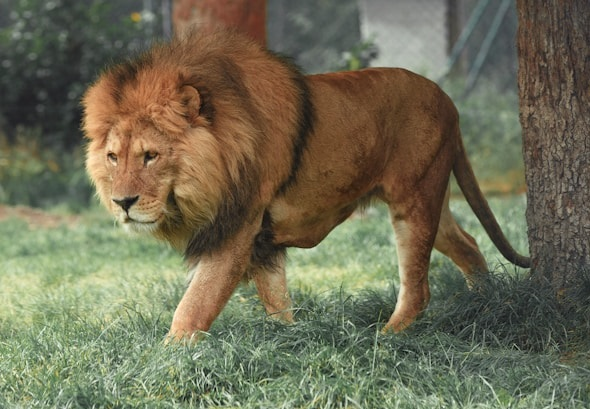

In [4]:
from PIL import Image
im = Image.open("lion.jpg")

im

In [5]:
import torch
from transformers import CLIPModel, CLIPProcessor
from torchvision import transforms
import kornia
from kornia.losses import total_variation # <-- Import TV Loss
from PIL import Image
import numpy as np

# Set device
device = "cuda" if torch.cuda.is_available() else "cpu"

# Load CLIP model and processor
clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(device)
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

# Define CLIP preprocessing transform
clip_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.48145466, 0.4578275, 0.40821073], std=[0.26862954, 0.26130258, 0.27577711]),
])

# Load original image (replace "lion.jpg" with your image path)
original_image = Image.open("lion.jpg").convert("RGB") # Ensure image is RGB
original_image_tensor = clip_transform(original_image).unsqueeze(0).to(device)

# Create optimizable image
image = original_image_tensor.clone().requires_grad_(True)

# Define target and negative texts
# Let's make the prompt a bit more descriptive
target_text = "A photo of a large African buffalo with dark fur and curved horns"
negative_text = "a prowling lion on the hunt"
texts = [target_text, negative_text]

# Precompute text features
text_inputs = processor(text=texts, return_tensors="pt", padding=True).to(device)
with torch.no_grad():
    text_features = clip_model.get_text_features(**text_inputs)
    text_features = text_features / text_features.norm(dim=-1, keepdim=True)
    target_text_feature = text_features[0]
    negative_text_feature = text_features[1]

# Define denormalization for SSIM/saving
mean = torch.tensor([0.48145466, 0.4578275, 0.40821073], device=device).view(1, 3, 1, 1)
std = torch.tensor([0.26862954, 0.26130258, 0.27577711], device=device).view(1, 3, 1, 1)

def denormalize(tensor):
    return tensor * std + mean

denormalized_original = denormalize(original_image_tensor)

# --- KEY PARAMETER CHANGES ---
# Set up optimizer with a slightly lower learning rate
optimizer = torch.optim.Adam([image], lr=0.008)

# Optimization loop with more steps
num_steps = 800

# Loss function weights - TUNE THESE!
lambda_ssim = 0.001    # Lowered to allow more change
lambda_neg = 1.0      # Weight for pushing away from the 'lion' text
lambda_tv = 0.0001    # Weight for smoothness regularization

print("Starting optimization...")
for step in range(num_steps):
    optimizer.zero_grad()
    
    # Compute CLIP similarity
    image_features = clip_model.get_image_features(pixel_values=image)
    image_features = image_features / image_features.norm(dim=-1, keepdim=True)
    
    similarity_target = (image_features @ target_text_feature.T).squeeze()
    similarity_negative = (image_features @ negative_text_feature.T).squeeze() # <-- Use the negative text
    
    # Compute SSIM
    denormalized_image = denormalize(image)
    ssim_value = kornia.metrics.ssim(denormalized_image, denormalized_original, window_size=11).mean()
    
    # Compute Total Variation Loss for smoothness
    tv_loss = total_variation(image).mean()
    
    # --- UPDATED TOTAL LOSS ---
    # We want to MAXIMIZE target similarity -> minimize -similarity_target
    # We want to MINIMIZE negative similarity -> maximize -similarity_negative or minimize +similarity_negative
    # We want to MAXIMIZE SSIM -> minimize (1 - ssim_value)
    # We want to MINIMIZE TV loss -> minimize +tv_loss
    loss = -similarity_target + (lambda_neg * similarity_negative) + lambda_ssim * (1 - ssim_value) + (lambda_tv * tv_loss)
    
    # Backpropagation
    loss.backward() # No need for retain_graph=True if we recompute everything each step
    optimizer.step()
    
    # Optional: Clamp the image to the valid normalized range to prevent instability
    with torch.no_grad():
        image.clamp_(-1.5, 1.5) # A reasonable range for normalized images

    if step % 100 == 0:
        print(f"Step {step}/{num_steps}, Loss: {loss.item():.4f}, Target Sim: {similarity_target.item():.4f}, SSIM: {ssim_value.item():.4f}")

print("Optimization finished.")

# Evaluate transformed image
with torch.no_grad():
    final_image_features = clip_model.get_image_features(pixel_values=image)
    final_image_features = final_image_features / final_image_features.norm(dim=-1, keepdim=True)
    logits = (final_image_features @ text_features.T).squeeze()
    probs = torch.softmax(logits, dim=0)
    final_denormalized_image = denormalize(image)
    final_ssim = kornia.metrics.ssim(final_denormalized_image, denormalized_original, window_size=11).mean()
    ssim_loss = 1 - final_ssim

# Print results
print(f"\n--- Results ---")
print(f"Probability of '{target_text}': {probs[0].item():.4f}")
print(f"Probability of '{negative_text}': {probs[1].item():.4f}")
print(f"Final SSIM loss: {ssim_loss.item():.4f}")

# Save transformed image
transformed_image_tensor = denormalize(image).squeeze().cpu().detach()
transformed_image_tensor = torch.clamp(transformed_image_tensor, 0, 1) # Clamp to valid 0-1 range before saving
transformed_image = (transformed_image_tensor.numpy().transpose(1, 2, 0) * 255).astype(np.uint8)
Image.fromarray(transformed_image).save("transformed_buffalo.jpg")
print("\nSaved transformed image to 'transformed_buffalo.jpg'")

Starting optimization...
Step 0/800, Loss: 1.2254, Target Sim: 0.2321, SSIM: 1.0000
Step 100/800, Loss: -0.0877, Target Sim: 0.5770, SSIM: 0.6787
Step 200/800, Loss: -0.2408, Target Sim: 0.6068, SSIM: 0.6120
Step 300/800, Loss: -0.3166, Target Sim: 0.6324, SSIM: 0.5805
Step 400/800, Loss: -0.3635, Target Sim: 0.6564, SSIM: 0.5610
Step 500/800, Loss: -0.3360, Target Sim: 0.6351, SSIM: 0.5469
Step 600/800, Loss: -0.3876, Target Sim: 0.6574, SSIM: 0.5369
Step 700/800, Loss: -0.3487, Target Sim: 0.6274, SSIM: 0.5277
Optimization finished.

--- Results ---
Probability of 'A photo of a large African buffalo with dark fur and curved horns': 0.6605
Probability of 'a prowling lion on the hunt': 0.3395
Final SSIM loss: 0.4800

Saved transformed image to 'transformed_buffalo.jpg'
